In [1]:
%matplotlib inline
import math
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [ ]:
def plot_schedule(total, schedule_fn):

# Existing MXNet Schedules

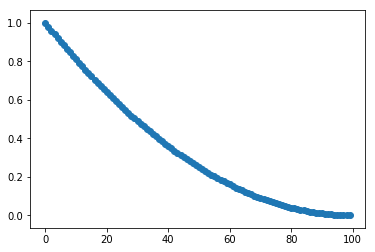

In [2]:
# quadratic function with minimum at 100 iterations
sched = mx.lr_scheduler.PolyScheduler(100, base_lr=1, pwr=2)
iterations = [i for i in range(100)]
lrs = [sched(i) for i in iterations]
plt.scatter(iterations, lrs)

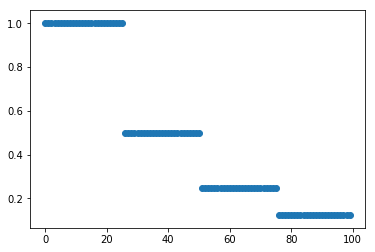

In [3]:
# doesn't have base_lr argument
sched = mx.lr_scheduler.FactorScheduler(step=25, factor=0.5)
sched.base_lr = 1
iterations = [i for i in range(100)]
lrs = [sched(i) for i in iterations]
plt.scatter(iterations, lrs)

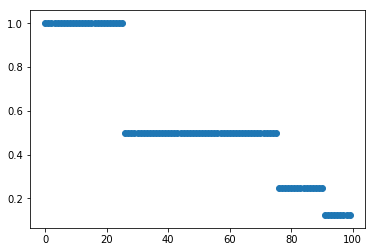

In [4]:
# doesn't have base_lr argument
sched = mx.lr_scheduler.MultiFactorScheduler(step=[25, 75, 90], factor=0.5)
sched.base_lr = 1
iterations = [i for i in range(100)]
lrs = [sched(i) for i in iterations]
plt.scatter(iterations, lrs)

# Custom Schedule Shapes

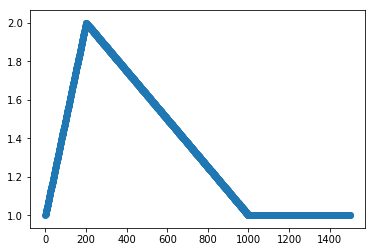

In [5]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1/(self.cycle_length*self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1/(self.cycle_length*(1-self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle
    

schedule = TriangularSchedule(min_lr=1, max_lr=2, cycle_length=1000, inc_fraction=0.2)
iterations = [i for i in range(1500)]
lrs = [schedule(i) for i in iterations]
plt.scatter(iterations, lrs)

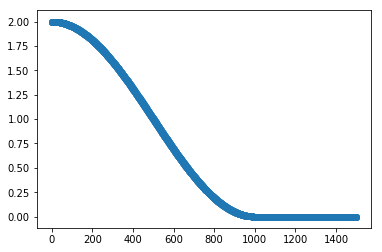

In [6]:
class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration*math.pi/self.cycle_length))/2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr


schedule = CosineAnnealingSchedule(min_lr=0, max_lr=2, cycle_length=1000)
iterations = [i for i in range(1500)]
lrs = [schedule(i) for i in iterations]
plt.scatter(iterations, lrs)

# Custom Cyclical Schedules

In [7]:
class CyclicalSchedule():
    def __init__(self, schedule, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule = schedule
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration-idx+cycle_length
        
        schedule = self.schedule(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

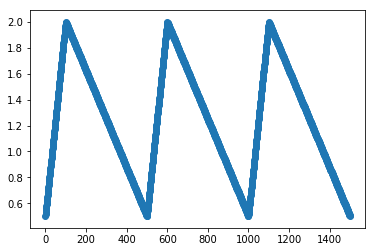

In [8]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, inc_fraction=0.2,
                            cycle_length=500, cycle_length_decay=1, cycle_magnitude_decay=1)
iterations = [i for i in range(1500)]
lrs = [schedule(i) for i in iterations]
plt.scatter(iterations, lrs)

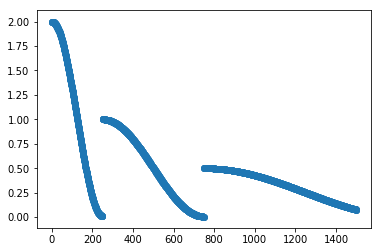

In [9]:
schedule = CyclicalSchedule(CosineAnnealingSchedule, min_lr=0.01, max_lr=2,
                            cycle_length=250, cycle_length_decay=2, cycle_magnitude_decay=0.5)
iterations = [i for i in range(1500)]
lrs = [schedule(i) for i in iterations]
plt.scatter(iterations, lrs)

# Burndown Schedules

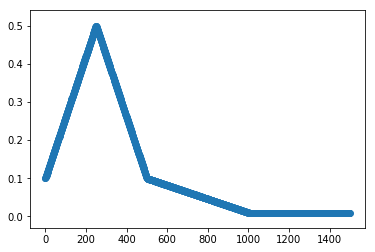

In [10]:
class TriangularOneCycleSchedule():
    def __init__(self, initial_lr, max_lr, cycle_length, burndown_length=0, final_lr=None):
        if (burndown_length > 0) and (final_lr is None):
            raise ValueError("Must specify final_lr when using burndown_length > 0.")
        if (burndown_length == 0) and (final_lr is not None):
            raise ValueError("Must specify burndown_length > 0 when using final_lr.")
        
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.burndown_length = burndown_length      
        self.final_lr = final_lr if (burndown_length > 0) else initial_lr
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            schedule = TriangularSchedule(min_lr=self.initial_lr, max_lr=self.max_lr, cycle_length=self.cycle_length)
            return schedule(iteration)
        elif iteration <= self.cycle_length + self.burndown_length:
            return self.initial_lr - ((self.initial_lr-self.final_lr)/self.burndown_length)*(iteration-self.cycle_length)
        else:
            return self.final_lr


schedule = TriangularOneCycleSchedule(initial_lr=0.1, max_lr=0.5, cycle_length=500, burndown_length=500, final_lr=0.01)
iterations = [i for i in range(1500)]
lrs = [schedule(i) for i in iterations]
plt.scatter(iterations, lrs)

# With training

In [11]:
mnist = mx.test_utils.get_mnist()
batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
from __future__ import print_function
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag
# define network
net = nn.Sequential()
with net.name_scope():
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(64, activation='relu'))
    net.add(nn.Dense(10))
gpus = mx.test_utils.list_gpus()
ctx =  [mx.gpu()] if gpus else [mx.cpu(0), mx.cpu(1)]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [12]:
cycle_length_epochs = 10
cycle_length_iters = (train_data.num_data/batch_size)*cycle_length_epochs
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.01, max_lr=0.03, inc_fraction=0.2,
                            cycle_length=cycle_length_iters, cycle_length_decay=1, cycle_magnitude_decay=1)

#trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'lr_scheduler': schedule})

In [13]:
epoch = 10
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropagate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

training acc at epoch 0: accuracy=0.705000
training acc at epoch 1: accuracy=0.892717
training acc at epoch 2: accuracy=0.914550
training acc at epoch 3: accuracy=0.928167
training acc at epoch 4: accuracy=0.936800
training acc at epoch 5: accuracy=0.943533
training acc at epoch 6: accuracy=0.948050
training acc at epoch 7: accuracy=0.951183
training acc at epoch 8: accuracy=0.953600
training acc at epoch 9: accuracy=0.955750
